In [1]:
import sys
sys.path.insert(0,'/projectnb/ace-ig/michelle/micsu/')


In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig
import os
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import skew 
from scipy.stats import kurtosis 


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score,cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix
)

#import mne

import pandas as pd
from scipy.stats import ttest_1samp
from scipy.stats import chisquare

from scipy.stats import ttest_ind
import ast


from sklearn.metrics import mean_squared_error
import scipy.stats as stats
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7")#, edgecolor="")

    return ax

def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

In [3]:
model_name = "LR"
PSD_features = "AcrossTrial"
root = '/projectnb/ace-ig/michelle/micsu/'


In [21]:


across_trial = np.load(root+'NEW_INPUTS/AcrossTrial_PSDfeatures.npy')
print("All subjects PSD features size ", across_trial.shape)

diagnosis = np.load(root+'NEW_INPUTS/diagnoses.npy')
print("Diagnosis array (true label) size ", diagnosis.shape)

sexs = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/sexs.npy')
print("Sex array  size ", sexs.shape)

all_srs = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/all_srs.npy')
print("SRS raw score size ", all_srs.shape)

all_srsT = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/all_srsT.npy')
print("SRS T score  size ", all_srsT.shape)

globcomp = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/globcomp.npy')
print("Glob comp - BRIEG  size ", globcomp.shape)


motorper = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/motorper.npy')
emoreact = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/emoreact.npy')
sens_care = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/sens_care.npy')
sens_adol = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/sens_adol.npy')

All subjects PSD features size  (190, 2, 4, 128, 5)
Diagnosis array (true label) size  (190,)
Sex array  size  (190,)
SRS raw score size  (190,)
SRS T score  size  (190,)
Glob comp - BRIEG  size  (190,)


In [22]:
male_srs = all_srsT[sexs==1]
male_diag = diagnosis[sexs==1]

male_srs[male_diag==0][male_srs[male_diag==0]<999].std()

4.345220547053404

In [6]:
female_srs = all_srsT[sexs==0]
female_diag = diagnosis[sexs==0]

female_srs[female_diag==0][female_srs[female_diag==0]<999].std()

5.013869652163774

In [7]:
male_diag.sum()

55.0

# Top features

In [7]:
# load absolute value of  model weights
all_weights = np.zeros((25, 2, 4, 128, 5))
for i in range(25):
    flat_LR_weights = np.abs(np.load('/projectnb/ace-ig/deeksha/weights/'+str(i)+'weights.npy'))
    LR_weights = np.reshape(flat_LR_weights, (2, 4, 128, 5))
    all_weights[i] = LR_weights
    
# get top 10% for all models
percent = 5
num_features = flat_LR_weights.size
top_num = int(num_features*percent/100)
print("Top", str(percent),"% = ", top_num, " number of features")
top_indices_arr = np.zeros((25, top_num))

for fold in range(25):
    model_weights = all_weights[fold]
    flat_model_weights = model_weights.reshape(-1)
    
   
    sorted_indices = np.argsort(-flat_model_weights)   # negative to do it decreasing order. 
    top_indices_flat = sorted_indices[:top_num]
    #top_indices_list = np.unravel_index(top_indices_flat, model_weights.shape)
    top_indices_arr[fold] = np.array(top_indices_flat)
    
top_indices_arr = np.int64(top_indices_arr)   

Top 5 % =  256  number of features


# Band and Type distribution

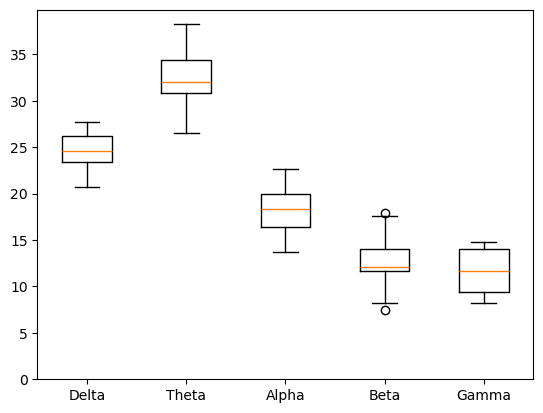

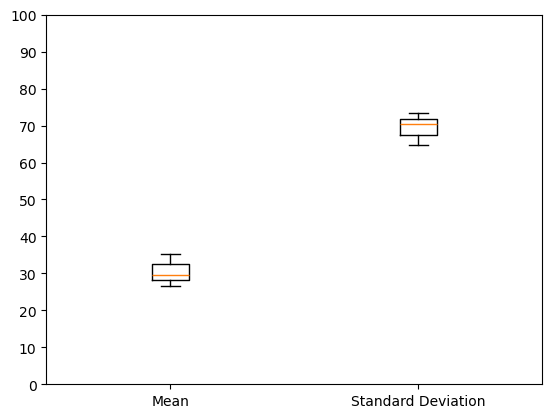

In [8]:
def count_values(array, feature_type):
    unique, counts = np.unique(array, return_counts=True)
    
    df = pd.DataFrame({
        f'{feature_type}': unique,
        'count': counts })
    df_sorted = df.sort_values(by='count', ascending=False).reset_index(drop=True)
    
    return df_sorted
    

each_band = np.zeros((25, 5))
each_feat = np.zeros((25, 2))
feature_types = ['across_trial_feature', 'band_feature', 'electrode', 'band']

for fold in range(25):
    
    x = []
    top_indices_flat = top_indices_arr[fold]
    top_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
    for i in range(4):
        x.append(count_values(top_indices[i], feature_types[i]))
        
        
    df = x[3]      # this is wrong. It should x[3]     
    names = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
    num_to_name = {i: name for i, name in enumerate(names)}
    #df.loc[4] = [4, 0]
    df['band_feature_name'] = df['band'].map(num_to_name)
    df['band_feature_name'] = pd.Categorical(df['band_feature_name'], categories=names, ordered=True)
    df = df.sort_values('band_feature_name')
    df['band_percent'] = df['count']/top_num*100
    band_percents = df['band_percent'].to_numpy()
    each_band[fold] = band_percents
   
    df = x[0]
    names = ["Mean", "Standard\nDeviation"]
    num_to_name = {i: name for i, name in enumerate(names)}
    df['across_trial_feature_name'] = df['across_trial_feature'].map(num_to_name)
    df['across_trial_feature_name'] = pd.Categorical(df['across_trial_feature_name'], categories=names, ordered=True)
    df = df.sort_values('across_trial_feature_name')
    df['feature_percent'] = df['count']/top_num*100
    band_percents = df['feature_percent'].to_numpy()
    each_feat[fold] = band_percents
    #print(band_percents)
    
    #print('\n')

plt.boxplot(each_band)
plt.xticks([1, 2, 3, 4, 5], ["Delta", "Theta", "Alpha", "Beta", "Gamma"])
plt.yticks(np.arange(0, 40, 5))
plt.show()

plt.boxplot(each_feat)
plt.xticks([1, 2], ["Mean", "Standard Deviation"])
plt.yticks(np.arange(0, 110, 10))
plt.show()
    

# Selection of best model 

In [9]:
# select best model feature positions
# from best "auroc" - 21st model weights are the best
best_top_indices_arr = top_indices_arr[20, :]
print(best_top_indices_arr.shape)

(256,)


In [10]:
regions = [[22, 21, 25, 26, 18, 127], #FP1
           [9, 10, 14, 8, 2, 126], #FP2
           [24, 27, 23, 28, 20, 19, 13], #F3
           [124, 3, 118, 123, 117, 4, 112], #F4
           [36, 42, 41, 35, 29, 30, 37], #C3
           [104, 111, 110, 103, 93, 105, 87], #C4
           [33, 34, 38, 32, 128], #F7
           [122, 116, 121, 1, 125], #F8
           [45, 46, 40, 39, 49, 44, 43, 48], #T7
           [108, 115, 109, 102, 113, 114, 120, 119], #T8
           [58, 63, 64, 57, 56, 50], #P7
          [96, 95, 99, 100, 107, 101], #P8
           [52, 51, 59, 60, 53, 47, 54], #P3
           [92, 86, 85, 91, 97, 98, 79, 72], #P4
           [70, 71, 66, 69, 74, 65, 73, 68, 81], #01
           [83, 76, 84, 82, 89, 90, 88, 94, 75], #02
           [62, 61, 78, 67, 77], #PZ
           [11, 16, 6, 12, 5, 15, 17], #FZ
           [7, 106, 31, 80, 55]] #CZ

for temp in range(19):
    while len(regions[temp])<9:
        regions[temp].append(200)       
           
regions = np.array(regions)-1

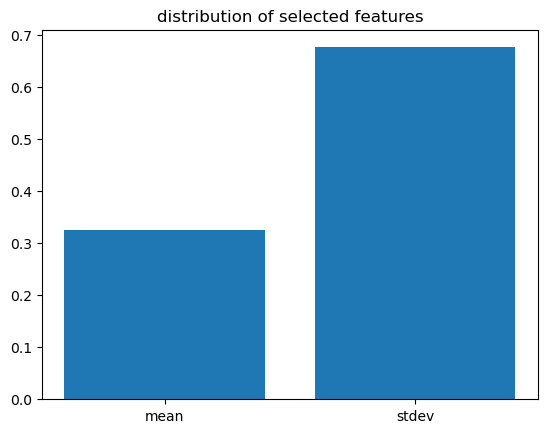

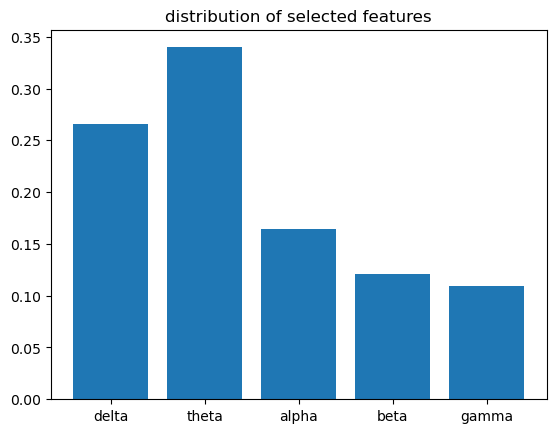

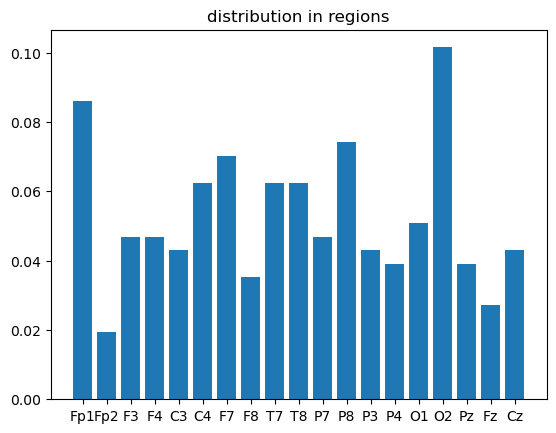

In [11]:
#std dev of which bands are important
stdbands = np.zeros(2)
for fold in range(1):
    top_indices_flat = best_top_indices_arr
    top_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
    for fpos in range(256):
        #if top_indices[0][fpos]==1:      
            stdbands[top_indices[0][fpos]] += 1
        #else:
            
stdbands /= stdbands.sum()
plt.bar(np.arange(1, 3), stdbands)
plt.xticks(np.arange(1, 3), ['mean', 'stdev'])
plt.title('distribution of selected features')
plt.show()

stdbands = np.zeros(5)
for fold in range(1):
    top_indices_flat = best_top_indices_arr
    top_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
    for fpos in range(256):
        #if top_indices[0][fpos]==1:      
            stdbands[top_indices[3][fpos]] += 1
        #else:
            
stdbands /= stdbands.sum()
plt.bar(np.arange(1, 6), stdbands)
plt.xticks(np.arange(1, 6), ['delta', 'theta', 'alpha', 'beta', 'gamma'])
plt.title('distribution of selected features')
plt.show()

top_std_feats = np.zeros(( 5, 19))

for fold in range(1):
    top_indices_flat = best_top_indices_arr
    top_indices = np.unravel_index(top_indices_flat, LR_weights.shape)  
    for fpos in range(256):
        trig = 0
        for reg in range(19):
            if  top_indices[2][fpos] in regions[reg]:  #top_indices[0][fpos]==1
                top_std_feats[ top_indices[3][fpos], reg] += 1
                trig += 1
        if trig == 0:
            print(top_indices[2][fpos])

top_std_feats = top_std_feats.sum(0)
top_std_feats /= top_std_feats.sum()

xpos = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'P3', 'P4', 'O1', 'O2', 'Pz', 'Fz', 'Cz']
#xpos = ['LPFC', 'RPFC', 'LF', 'RF', 'LC', 'RC', 'LT', 'RT',  'LP', 'RP', 'LO', 'RO', 'PM', 'FM', 'CM']
#f, ax = plt.subplots(1, 5, figsize=(22, 5))
feat = [ 'std']
band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']

j = 0
#for j in range(5):
        
plt.bar(np.arange(1, 20), top_std_feats)

plt.xticks(np.arange(1, 20), xpos)
plt.title('distribution in regions')
plt.show()

# Correlation in all features 

In [13]:
# load features and do correlation
# mark your selected features

In [14]:
print("All features shape : ", across_trial.shape)

All features shape :  (190, 2, 4, 128, 5)


(640, 190)


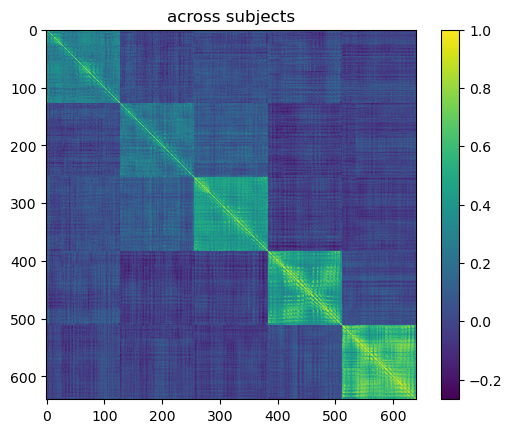

In [15]:
feats = np.transpose(across_trial, (0, 4, 3, 1, 2)).reshape(190, 5, 128, -1).mean(-1).reshape(190, -1).T
print(feats.shape)
corr = np.corrcoef(feats)
plt.imshow(corr)
plt.colorbar()
#plt.xticks(np.array([0, 1, 2, 3, 4, 5])*128, ['0', 'delta', 'theta', 'alpha', 'beta', 'gamma'])
#plt.yticks(np.array([0, 1, 2, 3, 4, 5])*128, ['0', 'delta', 'theta', 'alpha', 'beta', 'gamma'])
plt.title("across subjects")
plt.show()


(190, 5, 1024)


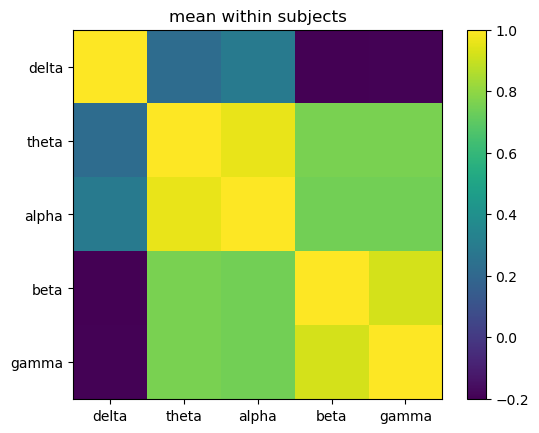

In [16]:
feats = np.transpose(across_trial, (0, 4, 3, 1, 2)).reshape(190, 5, -1)#.reshape(190, 5, -1)
print(feats.shape)
corr = np.zeros((190, 5, 5))
for j in range(190):
    corr[j]=np.corrcoef(feats[j])
corrmean = np.mean(corr, 0)
plt.imshow(corrmean)
plt.colorbar()
plt.xticks(np.arange(5), [ 'delta', 'theta', 'alpha', 'beta', 'gamma'])
plt.yticks(np.arange(5), [ 'delta', 'theta', 'alpha', 'beta', 'gamma'])
plt.title("mean within subjects")
plt.show()


# Correlation of selected feats of ASD with SRS score

In [12]:
top_indices_flat = best_top_indices_arr
sel_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
#sel_indices

In [13]:
sel_indices[0].shape

(256,)

In [14]:
# sel 256 feasts
print("All features shape : ", across_trial.shape)
print("SRS size: ", all_srs.shape)


sel_feats = np.zeros((190, 256))
for p in range(190):
    for feat in range(256):
        sel_feats[p, feat] = across_trial[p, sel_indices[0][feat], sel_indices[1][feat], sel_indices[2][feat], sel_indices[3][feat]]
print(sel_feats.shape)        
        
        
        
        

All features shape :  (190, 2, 4, 128, 5)
SRS size:  (190,)
(190, 256)


# mean of all 256

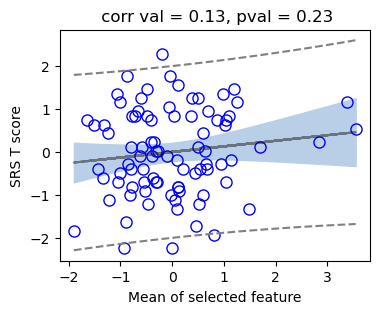

In [20]:

pheno = all_srsT
yname = 'SRS T score'

x = np.mean(sel_feats, 1)
x = x[pheno<999][diagnosis[pheno<999]==1]
y = pheno[pheno<999][diagnosis[pheno<999]==1]

y = (y - y.mean())/ y.std()
x = (x-x.mean())/x.std()

corr, pval = stats.pearsonr(x, y)
p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                                        # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4,3))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)

# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")
plt.title(" corr val = " +str(np.round(corr, 2)) + ', pval = '+str(np.round(pval, 2)))
plt.xlabel('Mean of selected feature')
plt.ylabel(yname)
plt.show()







# all 256 individually

In [ ]:

pheno = all_srsT
yname = 'SRS T score'

for f in range(256):
    x = sel_feats[:, f]
    x = x[pheno<999][diagnosis[pheno<999]==1]
    y = pheno[pheno<999][diagnosis[pheno<999]==1]

    y = (y - y.mean())/ y.std()
    x = (x-x.mean())/x.std()

    corr, pval = stats.pearsonr(x, y)
    
    if abs(corr)>0.05:   
        if pval<0.05:
            p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
            y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

            # Statistics
            n = y.size                                           # number of observations
            m = p.size                                                 # number of parameters
            dof = n - m                                                # degrees of freedom
            t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

            # Estimates of Error in Data/Model
            resid = y - y_model                                        # residuals; diff. actual data from predicted values
            chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
            chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
            s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

            # Plotting --------------------------------------------------------------------
            fig, ax = plt.subplots(figsize=(4,3))

            # Data
            ax.plot(
                x, y, "o", color="#b9cfe7", markersize=8, 
                markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
            )

            # Fit
            ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

            x2 = np.linspace(np.min(x), np.max(x), 100)
            y2 = equation(p, x2)

            # Confidence Interval (select one)
            plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
            #plot_ci_bootstrap(x, y, resid, ax=ax)

            # Prediction Interval
            pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
            ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
            ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
            ax.plot(x2, y2 + pi, "--", color="0.5")
            plt.title("feature "+ str(f)+" corr val = " +str(np.round(corr, 2)) + ', pval = '+str(np.round(pval, 2)))
            plt.xlabel('Individual selected feature')
            plt.ylabel(yname)
            plt.show()







In [15]:
#after aggregation of selected feats

band = ['delta', 'theta', 'alpha', 'beta', 'gamma']
xpos = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'P3', 'P4', 'O1', 'O2', 'Pz', 'Fz', 'Cz']

aggregated_feat = np.zeros((190, 5, 19))
running_count = np.zeros((190, 5, 19))
for j in range(190):
    for feat in range(256):
        
        band =  sel_indices[3][feat]
        pos  =  sel_indices[2][feat]
        
        for r in range(19):
            if pos in regions[r]:
                elec = r
                electrode_set = regions[r]
                if 199 in regions[r]:
                    t = np.where(regions[r] == 199)[0][0]
                electrode_set = electrode_set[:t]
                
                break

        # across_trial[p, sel_indices[0][feat], sel_indices[1][feat], sel_indices[2][feat], sel_indices[3][feat]]  
        #aggregated_feat[j, band, elec] = across_trial[j, 1][:, pos, :].sum(-1).mean(-1)
        
        aggregated_feat[j, band, elec] = aggregated_feat[j, band, elec] * running_count[j, band, elec] + across_trial[j, sel_indices[0][feat], sel_indices[1][feat], sel_indices[2][feat], sel_indices[3][feat]]  
        
        running_count[j, band, elec] += 1
        aggregated_feat[j, band, elec]/= running_count[j, band, elec]


In [ ]:
pheno = all_srsT
yname = 'SRS T' 

for b in range(5):
    for pos in range(19):
        x = aggregated_feat[:, b, pos]
        if x.min() == x.max() == 0:
            continue
        x = x[diagnosis==1]
        y = pheno[diagnosis==1]
        
        x = x[y<999]
        
        y = y[y<999]
        
        y = (y - y.mean())/ y.std()
        x = (x-x.mean())/x.std()
        
        corr, pval = stats.pearsonr(x, y)
        
        if abs(corr)>0.1:
            
            if pval<0.05:
                #print(np.round(corr, 2),  band[b], xpos[pos], np.round(pval, 2), 'significant')
                
                p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
                y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

                # Statistics
                n = y.size                                           # number of observations
                m = p.size                                                 # number of parameters
                dof = n - m                                                # degrees of freedom
                t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

                # Estimates of Error in Data/Model
                resid = y - y_model                                        # residuals; diff. actual data from predicted values
                chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
                chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
                s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

                # Plotting --------------------------------------------------------------------
                fig, ax = plt.subplots(figsize=(4,3))

                # Data
                ax.plot(
                    x, y, "o", color="#b9cfe7", markersize=8, 
                    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
                )

                # Fit
                ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

                x2 = np.linspace(np.min(x), np.max(x), 100)
                y2 = equation(p, x2)

                # Confidence Interval (select one)
                plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
                #plot_ci_bootstrap(x, y, resid, ax=ax)

                # Prediction Interval
                pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
                ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
                ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
                ax.plot(x2, y2 + pi, "--", color="0.5")
                plt.title(band_names[b]+' '+xpos[pos]+" corr val = " +str(np.round(corr, 2)) + ', pval = '+str(np.round(pval, 2)))
                plt.xlabel('aggregated feature')
                plt.ylabel(yname)
                plt.show()
    #print('\n')




# regression analysis with all feats


In [25]:
ace_pheno = pd.read_csv("/projectnb/ace-ig/ace_phenotype.csv")
ace_pheno['ID'] = ace_pheno['Site ID'].str[3:]

In [26]:
ace_pheno[:2]

,Site ID,GUID,New ID,Bioidentifier ID,site,race,ethnic group,Biological Mother's income,Biological Father's income,Household Income,...,Conduct Problems,Pubertal Development Scale Total,Pubertal Development Scale Total.1,Unnamed: 142,Social Affect Total,Behavioral Total.1,ADOS Total,Comparison Score,ADOS Version.1,ID
0,UCL50703,NDARWG962LXY,KP654503,wb.KP654503,UCL,American Indian/Alaska Native,Hispanic or Latino Descent,8,6,9,...,50,12,18,NaN,NaN,NaN,NaN,NaN,NaN,50703
1,HAR33103,NDARBU850GVM,KP697703,MH0175774,HAR,Asian,Not of Hispanic or Latino Descent,1,2,2,...,53,8,12,NaN,NaN,NaN,NaN,NaN,NaN,33103


data = "/projectnb/ace-ig/deeksha/day-2/processed/"
ace_pheno = pd.read_csv("/projectnb/ace-ig/ace_phenotype.csv")
ace_pheno['ID'] = ace_pheno['Site ID'].str[3:]

def get_PSD(trials64_eeg, filename, fs=512):
    freq, psd = sig.welch(trials64_eeg, fs, window='hamming',nperseg=512, noverlap=256)

    name_parts = filename.split(".")[:2]
    family, member_num = name_parts
    member_num = member_num[:2]
    ID = family+member_num
    
    interview_age = ace_pheno.loc[ace_pheno['ID']==ID, 'Interview Age (months)'].values[0]
    scan_age = ace_pheno.loc[ace_pheno['ID']==ID, 'Scan Age (months)'].values[0]
    site = ace_pheno.loc[ace_pheno['ID']==ID, 'site'].values[0]
    GUID = ace_pheno.loc[ace_pheno['ID']==ID, 'GUID'].values[0]
    
    
    return GUID, family, interview_age, scan_age, site

GUIDs, familys, interview_ages, scan_ages, sites = [], [], [],[],[]

i = 0
for filename in os.listdir(data):
    raw = mne.io.read_epochs_eeglab(data+filename)
    full_eeg = raw.get_data()
    if full_eeg.shape[0]<64:
        # print(filename)
        # break
        continue
    trials_64_eeg = full_eeg[:64]
    GUID, family, interview_age, scan_age, site = get_PSD(full_eeg.mean(0), filename, fs=500)

    
    GUIDs.append(GUID)
    familys.append(family)
    interview_ages.append(interview_age)
    scan_ages.append(scan_age)
    sites.append(site)
    i+=1

GUIDs = np.array(GUIDs)
familys = np.array(familys)
interview_ages = np.array(interview_ages)
scan_ages = np.array(scan_ages)
sites  = np.array(sites)

np.save('/projectnb/ace-ig/deeksha/GUIDs.npy', GUIDs)
np.save('/projectnb/ace-ig/deeksha/familys.npy', familys)
np.save('/projectnb/ace-ig/deeksha/interview_ages.npy', interview_ages)
np.save('/projectnb/ace-ig/deeksha/scan_ages.npy', scan_ages)
np.save('/projectnb/ace-ig/deeksha/sites.npy', sites)

In [23]:
GUIDs = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/GUIDs.npy')
familys = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/familys.npy')
interview_ages = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/interview_ages.npy')
scan_ages = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/scan_ages.npy')
sites = np.load('/projectnb/ace-ig/deeksha/pheno_arrays/sites.npy')

In [28]:
sens_care.shape

(190,)

In [24]:
# make datafframes

df = {'diagnosis' : diagnosis[diagnosis==1], 
       'sex': sexs[diagnosis==1], 
     'srs': all_srs[diagnosis==1], 
     'srsT': all_srsT[diagnosis==1], 
     'brief': globcomp[diagnosis==1], 
      'site': sites[diagnosis==1], 
      'family': familys[diagnosis==1], 
      'interview_age': interview_ages[diagnosis==1], 
      'scan_age': scan_ages[diagnosis==1], 
      'GUID': GUIDs[diagnosis==1], 
      'emoreact': emoreact[diagnosis==1] ,
      'motorper':motorper[diagnosis==1], 
      'sens_care': sens_care[diagnosis==1], 
      'sens_adol':sens_adol[diagnosis==1]
     }  #add GUID, family, interview_age, scan_age, site


for j in range(256):
    keyname = 'selfeat_'+str(j)
    df[keyname] = sel_feats[:, j][diagnosis==1]
    
df = pd.DataFrame(df)
df[:3]

,diagnosis,sex,srs,srsT,brief,site,family,interview_age,scan_age,GUID,...,selfeat_246,selfeat_247,selfeat_248,selfeat_249,selfeat_250,selfeat_251,selfeat_252,selfeat_253,selfeat_254,selfeat_255
0,1.0,0.0,90.0,76.0,76.0,SCR,755,189,193.336756,NDARED014HTN,...,6.150225e-16,4.120417,7.251856e-14,-0.156182,3.149688e-12,2.190801,1.209186,0.845661,3.673977e-12,2.673759
1,1.0,0.0,118.0,88.0,76.0,SCR,713,208,209.051335,NDARZH274HDN,...,5.822059e-16,1.951309,4.626217e-14,-0.257052,2.307408e-12,2.810658,1.287455,0.797177,6.136063e-13,2.485748
2,1.0,1.0,43.0,54.0,49.0,SCR,772,187,189.924025,NDARWB020XRL,...,9.686656e-16,1.660431,3.899597e-14,-0.240528,1.957341e-12,2.465935,1.291635,0.894959,4.409484e-12,3.160411


In [30]:
def regression(df, age_type):
    import statsmodels.formula.api as smf

    # df['interview_age'] = df['interview_age'].astype('float')
    # df['interview_age'] = np.array(df['interview_age']) + np.random.randn(len(df['interview_age']))/100
    pheno = 'srsT'
    df_filtered = df[df[pheno] != 999]
    
    all_pvals = np.zeros((256,3))

    #band_names = ["delta", "theta", "alpha", "gamma", "beta"]
    count = 0 
    for feat in range(256):

        model = smf.mixedlm(f"{pheno} ~ selfeat_{feat} + {age_type}_age + C(sex)", #C(diagnosis)  - categorical
                            df, 
                            groups="site",
                            vc_formula={'family': '0+C(family)'}
                           )
            # random intercept for site, random slope for family
            # 1+ = intercept and slope correlated, 0+ = not correlated
        #https://www.pythonfordatascience.org/mixed-effects-regression-python/

        x = model.fit()
        pvals = x.pvalues.values

        all_pvals[feat] = pvals[1:4]
        #if pvals[2]<0.05: 
        #    print(x.summary())
        #    count += 1
    print(count)
    return all_pvals

In [31]:
import warnings
warnings.filterwarnings('ignore')


In [32]:
pvals_og_interview = regression(df, "interview")

0


In [33]:
17/256

0.06640625

# regression analysis with aggregated feats


In [34]:
import warnings
warnings.filterwarnings("ignore")


In [35]:
aggregated_feat.shape

(190, 5, 19)

In [28]:
# make dataframes

# make datafframes

df = {'diagnosis' : diagnosis[diagnosis==1], 
       'sex': sexs[diagnosis==1], 
     'srs': all_srs[diagnosis==1], 
     'srsT': all_srsT[diagnosis==1], 
     'brief': globcomp[diagnosis==1], 
      'site': sites[diagnosis==1], 
      'family': familys[diagnosis==1], 
      'interview_age': interview_ages[diagnosis==1], 
      'scan_age': scan_ages[diagnosis==1], 
      'GUID': GUIDs[diagnosis==1], 
       'emoreact': emoreact[diagnosis==1] ,
      'motorper':motorper[diagnosis==1], 
      'sens_care': sens_care[diagnosis==1], 
      'sens_adol':sens_adol[diagnosis==1]
     }  #add GUID, family, interview_age, scan_age, site


for b, band in enumerate(band_names):
    for p, pos in enumerate(xpos):
    
        keyname = 'aggfeat_'+band + '_' + pos
        df[keyname] = aggregated_feat[:, b, p][diagnosis==1]

df = pd.DataFrame(df)
df[:3]

,diagnosis,sex,srs,srsT,brief,site,family,interview_age,scan_age,GUID,...,aggfeat_gamma_T8,aggfeat_gamma_P7,aggfeat_gamma_P8,aggfeat_gamma_P3,aggfeat_gamma_P4,aggfeat_gamma_O1,aggfeat_gamma_O2,aggfeat_gamma_Pz,aggfeat_gamma_Fz,aggfeat_gamma_Cz
0,1.0,0.0,90.0,76.0,76.0,SCR,755,189,193.336756,NDARED014HTN,...,0.0,1.960896,1.224581,3.432421e-14,2.221501,1.882269,1.182995,0.0,0.722897,0.0
1,1.0,0.0,118.0,88.0,76.0,SCR,713,208,209.051335,NDARZH274HDN,...,0.0,1.176860,0.622906,3.751250e-15,1.434328,1.374411,0.946701,0.0,0.615093,0.0
2,1.0,1.0,43.0,54.0,49.0,SCR,772,187,189.924025,NDARWB020XRL,...,0.0,1.187092,0.546237,1.273290e-14,1.499304,0.914177,0.857194,0.0,0.704433,0.0


In [37]:
def regression(df, age_type):
    import statsmodels.formula.api as smf

    pheno = 'srsT'
    df_filtered = df[df[pheno] != 999]
    
    
    pvals_all = []
    coeffs_all =[]
    for b, band in enumerate(band_names):
        for p, pos in enumerate(xpos):
    
            #keyname = 'aggfeat_'+band + '_' + pos
            print(band, pos)
            model = smf.mixedlm(f" aggfeat_{band}_{pos} ~ {pheno} + {age_type}_age + C(sex)", #C(diagnosis)  - categorical
                                df, 
                                groups="site",
                                vc_formula={'family': '0+C(family)'}
                               )
                # random intercept for site, random slope for family
                # 1+ = intercept and slope correlated, 0+ = not correlated
            #https://www.pythonfordatascience.org/mixed-effects-regression-python/

            x = model.fit( )
            pvals = x.pvalues.values
            #print( x.cov_re)
            #all_pvals[feat] = pvals[1:4]
            #if pvals[2]<0.05: 
            #    print(x.summary())
            print(x.summary())
            #print(band, pos, pvals[2])
            pvals_all.append(pvals[2])
            coeffs_all.append(x)
            return x
    return pvals_all

In [38]:
def regression_joint(df, age_type):
    import statsmodels.formula.api as smf

    pheno = 'srsT'
    df_filtered = df[df[pheno] != 999]
    
    
    pvals_all = []
    coeffs_all =[]
    #input_string = f" aggfeat_{band}_{pos} ~ {pheno} + {age_type}_age + C(sex)"
    inputstring = f"{pheno} ~ "
    for b, band in enumerate(band_names):
        for p, pos in enumerate(xpos):
            inputstring += f"aggfeat_{band}_{pos} + "
    inputstring += f"{age_type}_age + C(sex)"
    print(inputstring)
    model = smf.mixedlm(inputstring, #C(diagnosis)  - categorical
                        df, 
                        groups="site",
                        vc_formula={'family': '0+C(family)'}
                        )
        # random intercept for site, random slope for family
        # 1+ = intercept and slope correlated, 0+ = not correlated
    #https://www.pythonfordatascience.org/mixed-effects-regression-python/

    x = model.fit( )
    pvals = x.pvalues.values

    print(x.summary())

    pvals_all.append(pvals[2])
    coeffs_all.append(x)
 
    return x

In [39]:
x = regression_joint(df, "scan")

srsT ~ aggfeat_delta_Fp1 + aggfeat_delta_Fp2 + aggfeat_delta_F3 + aggfeat_delta_F4 + aggfeat_delta_C3 + aggfeat_delta_C4 + aggfeat_delta_F7 + aggfeat_delta_F8 + aggfeat_delta_T7 + aggfeat_delta_T8 + aggfeat_delta_P7 + aggfeat_delta_P8 + aggfeat_delta_P3 + aggfeat_delta_P4 + aggfeat_delta_O1 + aggfeat_delta_O2 + aggfeat_delta_Pz + aggfeat_delta_Fz + aggfeat_delta_Cz + aggfeat_theta_Fp1 + aggfeat_theta_Fp2 + aggfeat_theta_F3 + aggfeat_theta_F4 + aggfeat_theta_C3 + aggfeat_theta_C4 + aggfeat_theta_F7 + aggfeat_theta_F8 + aggfeat_theta_T7 + aggfeat_theta_T8 + aggfeat_theta_P7 + aggfeat_theta_P8 + aggfeat_theta_P3 + aggfeat_theta_P4 + aggfeat_theta_O1 + aggfeat_theta_O2 + aggfeat_theta_Pz + aggfeat_theta_Fz + aggfeat_theta_Cz + aggfeat_alpha_Fp1 + aggfeat_alpha_Fp2 + aggfeat_alpha_F3 + aggfeat_alpha_F4 + aggfeat_alpha_C3 + aggfeat_alpha_C4 + aggfeat_alpha_F7 + aggfeat_alpha_F8 + aggfeat_alpha_T7 + aggfeat_alpha_T8 + aggfeat_alpha_P7 + aggfeat_alpha_P8 + aggfeat_alpha_P3 + aggfeat_alpha_P4 +

LinAlgError: Singular matrix

In [ ]:
for j in range(5):

    print(('& ').join([str(round(p, 2)) for p in pvals_og_interview[19*j:19*(j+1)]]))

0.5& nan& 0.88& 0.38& 0.48& 0.88& 0.19& 0.63& 0.52& 0.54& 0.52& 0.97& 0.11& 0.02& 0.54& 0.17& nan& 0.37& 0.01
0.28& 0.64& 0.37& 0.52& 0.29& 0.18& 0.88& 0.48& 0.06& 0.39& 0.41& 0.09& 0.8& 0.25& 0.61& 0.0& 0.06& nan& 0.73
nan& 0.95& 0.35& 0.36& 0.82& 0.6& 0.73& 0.19& 0.25& 0.02& 0.87& 0.08& 0.86& 0.96& 0.37& 0.8& 0.32& 0.35& 0.02
0.88& nan& nan& 0.84& 0.46& 0.78& 0.16& 0.3& nan& nan& 0.54& 0.38& 0.4& 0.17& 0.11& 0.87& 0.24& nan& 0.56
0.39& nan& nan& 0.95& nan& 0.46& 0.47& 0.3& 0.28& nan& 0.74& 0.18& 0.46& 0.7& 0.75& 0.91& nan& 0.66& nan


# Male and Female Separate

In [20]:
# make dataframes

# make datafframes

df = {'diagnosis' : diagnosis[diagnosis==1], 
       'sex': sexs[diagnosis==1], 
     'srs': all_srs[diagnosis==1], 
     'srsT': all_srsT[diagnosis==1], 
     'brief': globcomp[diagnosis==1], 
      'site': sites[diagnosis==1], 
      'family': familys[diagnosis==1], 
      'interview_age': interview_ages[diagnosis==1], 
      'scan_age': scan_ages[diagnosis==1], 
      'GUID': GUIDs[diagnosis==1], 
      'emoreact': emoreact[diagnosis==1] ,
      'motorper':motorper[diagnosis==1], 
      'sens_care': sens_care[diagnosis==1], 
      'sens_adol':sens_adol[diagnosis==1]
     }  #add GUID, family, interview_age, scan_age, site


for b, band in enumerate(band_names):
    for p, pos in enumerate(xpos):
    
        keyname = 'aggfeat_'+band + '_' + pos
        df[keyname] = aggregated_feat[:, b, p][diagnosis==1]

df = pd.DataFrame(df)


NameError: name 'sites' is not defined

In [29]:
maledf = df[df['sex'] == 1]
femaledf = df[df['sex'] == 0]

In [ ]:
def regression(df, age_type):
    import statsmodels.formula.api as smf

 
    pheno = 'srsT'
    df_filtered = df[df[pheno] != 999]
    
    pvals_all = []
    count = 0
    for b, band in enumerate(band_names):
        for p, pos in enumerate(xpos):
    
            #keyname = 'aggfeat_'+band + '_' + pos

            model = smf.mixedlm(f"aggfeat_{band}_{pos} ~ {pheno} + {age_type}_age ", #C(diagnosis) + C(sex)  - categorical
                                df, 
                                groups="site",
                                vc_formula={'family': '0+C(family)'}
                               )
                # random intercept for site, random slope for family
                # 1+ = intercept and slope correlated, 0+ = not correlated
            #https://www.pythonfordatascience.org/mixed-effects-regression-python/

            x = model.fit()
            pvals = x.pvalues.values

            #pvals_all[feat] = pvals[1:4]
            pvals_all.append(pvals[1])
            if pvals[1]<0.05: 
                print(x.summary())
            #print(x.rsquared)
            #print( x.cov_re)
            fixed_effects_variance = x.fe_params.var()  # Variance of fixed effects
            random_effects_variance = 1e-04#x.cov_re.iloc[0, 0]  # Random effect variance (site)
            residual_variance = x.scale  # Residual variance

            # Calculate the total variance
            total_variance = fixed_effects_variance + random_effects_variance + residual_variance

            # Calculate proportion of explained variance (pseudo-R^2)
            explained_variance_proportion = fixed_effects_variance / total_variance
            #if round(explained_variance_proportion, 2) > 0.9:
            #    print(band, pos)
            #    print(f"Proportion of explained variance: {explained_variance_proportion}")
            #    count += 1

    return pvals_all, count
    

In [ ]:
pvals_og_interview, c = regression(maledf, "interview")

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aggfeat_delta_C3
No. Observations: 55      Method:             REML            
No. Groups:       4       Scale:              0.0022          
Min. group size:  1       Log-Likelihood:     51.5537         
Max. group size:  22      Converged:          Yes             
Mean group size:  13.8                                        
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        0.459     0.037  12.371  0.000   0.386   0.532
sens_care       -0.000     0.000  -2.635  0.008  -0.000  -0.000
interview_age    0.000     0.000   0.314  0.754  -0.000   0.001
family Var       0.002                                         

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aggfeat_delta_C4
No. Observ

In [ ]:
for j in range(5):

    print(('& ').join([str(round(p, 2)) for p in pvals_og_interview[19*j:19*(j+1)]]))

0.12& nan& 0.16& 0.38& 0.01& 0.02& 0.08& 0.8& 0.19& 0.55& 0.99& 0.01& 0.54& 0.7& 0.22& 0.03& nan& 0.57& 0.59
0.21& 0.69& 0.18& 0.96& 0.77& 0.14& 0.92& 0.77& 0.44& 0.87& 0.62& 0.94& 0.72& 0.99& 0.1& 0.31& 0.0& nan& 0.62
nan& 0.55& 0.32& 0.83& 0.72& 0.66& 0.11& 0.42& 0.14& 0.6& 0.03& 0.33& 0.0& 0.35& 0.52& 0.7& 0.6& 0.67& 0.18
0.02& nan& nan& 0.9& 0.51& 0.5& 0.02& 0.02& nan& nan& 0.06& 0.13& 0.54& 0.79& 0.0& 0.01& 0.29& nan& 0.84
0.31& nan& nan& 0.72& nan& 0.01& 0.55& 0.61& 0.64& nan& 0.34& 0.18& 0.55& 0.74& 0.52& 0.4& nan& 0.19& nan


In [ ]:
pvals_og_interview, c = regression(femaledf, "interview")

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aggfeat_delta_F4
No. Observations: 39      Method:             REML            
No. Groups:       4       Scale:              0.0005          
Min. group size:  1       Log-Likelihood:     59.1952         
Max. group size:  19      Converged:          Yes             
Mean group size:  9.8                                         
---------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept       0.616     0.003  219.280  0.000   0.611   0.622
sens_care       0.000     0.000    2.356  0.018   0.000   0.000
interview_age  -0.000     0.000   -5.875  0.000  -0.001  -0.000
family Var      0.000                                          

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aggfeat_delta_F7
No. Observ

In [ ]:
for j in range(5):

    print(('& ').join([str(round(p, 2)) for p in pvals_og_interview[19*j:19*(j+1)]]))

0.85& nan& 0.47& 0.02& 0.38& 0.08& 0.04& 0.0& 0.97& 0.83& 0.77& 0.0& 0.3& 0.12& 0.89& 0.63& nan& 0.68& 0.69
0.67& 0.09& 0.44& 0.59& 0.55& 0.15& 0.0& 0.86& 0.44& 0.1& 0.32& 0.51& 0.07& 0.7& 0.56& 0.96& 0.48& nan& 0.26
nan& 0.37& 0.79& 0.23& 0.62& 0.43& 0.04& 0.04& 0.85& 0.47& 0.2& 0.33& 0.27& 0.84& 0.14& 0.7& 0.64& 0.5& 0.08
0.47& nan& nan& 0.15& 0.54& 0.3& 0.04& 0.0& nan& nan& 0.44& 0.26& 0.07& 0.84& 0.57& 0.95& 0.71& nan& 0.44
0.57& nan& nan& 0.65& nan& 0.15& 0.12& 0.11& 0.0& nan& 0.14& 0.46& 0.56& 0.02& 0.22& 0.16& nan& 0.53& nan


# Patrial Correlations

In [30]:
list(df.keys())

['diagnosis',
 'sex',
 'srs',
 'srsT',
 'brief',
 'site',
 'family',
 'interview_age',
 'scan_age',
 'GUID',
 'emoreact',
 'motorper',
 'sens_care',
 'sens_adol',
 'aggfeat_delta_Fp1',
 'aggfeat_delta_Fp2',
 'aggfeat_delta_F3',
 'aggfeat_delta_F4',
 'aggfeat_delta_C3',
 'aggfeat_delta_C4',
 'aggfeat_delta_F7',
 'aggfeat_delta_F8',
 'aggfeat_delta_T7',
 'aggfeat_delta_T8',
 'aggfeat_delta_P7',
 'aggfeat_delta_P8',
 'aggfeat_delta_P3',
 'aggfeat_delta_P4',
 'aggfeat_delta_O1',
 'aggfeat_delta_O2',
 'aggfeat_delta_Pz',
 'aggfeat_delta_Fz',
 'aggfeat_delta_Cz',
 'aggfeat_theta_Fp1',
 'aggfeat_theta_Fp2',
 'aggfeat_theta_F3',
 'aggfeat_theta_F4',
 'aggfeat_theta_C3',
 'aggfeat_theta_C4',
 'aggfeat_theta_F7',
 'aggfeat_theta_F8',
 'aggfeat_theta_T7',
 'aggfeat_theta_T8',
 'aggfeat_theta_P7',
 'aggfeat_theta_P8',
 'aggfeat_theta_P3',
 'aggfeat_theta_P4',
 'aggfeat_theta_O1',
 'aggfeat_theta_O2',
 'aggfeat_theta_Pz',
 'aggfeat_theta_Fz',
 'aggfeat_theta_Cz',
 'aggfeat_alpha_Fp1',
 'aggfeat_alp

In [17]:
from pingouin import partial_corr

In [62]:
rvals, pvals = [], []
for b, band in enumerate(band_names):
    for p, pos in enumerate(xpos):
        #if df[f"aggfeat_{band}_{pos}"].min() == df[f"aggfeat_{band}_{pos}"].max() == 0:
        #    print(f"aggfeat_{band}_{pos}")
        res = partial_corr(data=df, x=f"aggfeat_{band}_{pos}", y='sens_adol', covar=[ 'interview_age',  'sex'], method='pearson')
        pvals.append(res['p-val'].item())
        rvals.append(res['r'].item())
        if res['p-val'].item()<0.05:
            print(band, pos, res['r'].item(), res['CI95%'].item(), res['p-val'].item())

delta C3 0.2114997538452751 [0.01 0.4 ] 0.04298518611725079
delta F7 0.22199739785604053 [0.02 0.41] 0.033434544899364566
delta O2 0.23794162291885515 [0.03 0.42] 0.022373916377593
delta Cz 0.21548621987160818 [0.01 0.4 ] 0.039120807252056036
theta Fp2 -0.21035700389466394 [-0.4  -0.01] 0.04414970760636236
alpha F8 0.2164440412061327 [0.01 0.4 ] 0.03823685185006306
alpha T8 0.20594415699334775 [0.   0.39] 0.048895066988622955


In [57]:
for j in range(5):

    print(('& ').join([str(round(p, 2)) for p in rvals[19*j:19*(j+1)]]))


print('%')


for j in range(5):

    print(('& ').join([str(round(p, 2)) for p in pvals[19*j:19*(j+1)]]))

0.07& nan& 0.05& 0.09& 0.07& -0.01& 0.14& -0.05& -0.07& 0.07& 0.07& -0.05& 0.05& 0.05& -0.06& 0.14& nan& -0.1& 0.26
-0.11& 0.05& -0.09& -0.06& 0.11& -0.14& -0.02& 0.07& -0.19& 0.09& -0.08& -0.18& -0.02& -0.13& -0.05& -0.31& -0.19& nan& -0.04
nan& 0.01& -0.09& -0.1& -0.02& -0.05& 0.04& 0.14& -0.12& 0.24& -0.02& 0.19& -0.02& 0.01& -0.09& 0.03& -0.1& 0.1& -0.23
-0.02& nan& nan& 0.02& -0.07& 0.03& -0.05& -0.05& nan& nan& -0.05& -0.09& -0.08& -0.13& 0.17& -0.02& -0.12& nan& -0.05
-0.05& nan& nan& -0.01& nan& -0.05& -0.08& -0.11& -0.11& nan& 0.04& -0.14& -0.05& -0.04& -0.03& -0.02& nan& 0.03& nan
%
0.51& nan& 0.62& 0.39& 0.49& 0.89& 0.18& 0.63& 0.52& 0.54& 0.52& 0.62& 0.62& 0.62& 0.55& 0.18& nan& 0.36& 0.01
0.28& 0.64& 0.38& 0.57& 0.29& 0.2& 0.88& 0.48& 0.06& 0.39& 0.43& 0.09& 0.87& 0.23& 0.65& 0.0& 0.07& nan& 0.73
nan& 0.95& 0.38& 0.36& 0.86& 0.6& 0.71& 0.18& 0.25& 0.02& 0.88& 0.08& 0.87& 0.96& 0.38& 0.8& 0.33& 0.35& 0.03
0.86& nan& nan& 0.84& 0.48& 0.78& 0.62& 0.62& nan& nan& 0.62& 0.4& 0.

In [55]:
import statsmodels.stats.multitest as multi

In [63]:
reject, p_values_corrected, _, _ = multi.multipletests(pvals, method='bonferroni')



In [64]:
p_values_corrected

array([ 1., nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  1., nan,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., nan, nan,  1.,  1.,  1.,  1.,  1.,
       nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  1.,  1., nan,
       nan,  1., nan,  1.,  1.,  1.,  1., nan,  1.,  1.,  1.,  1.,  1.,
        1., nan,  1., nan])